In [1]:
!pip install -r ../../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'Baseline'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dataaugmentationlib

import math

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

X_train, Y_train = dataaugmentationlib.add_gaussian_noise_and_concatenate_with_signals(X_train, Y_train)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(660000, 2, 128)
[2, 128]


In [11]:
model = neural_networks.baseline(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2, 128)            114816    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2, 128)            82048     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 128)            114816    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 128)            82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 128)            0     

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/581 [..............................] - ETA: 1:58:26 - loss: 8.4214

  5/581 [..............................] - ETA: 9s - loss: 8.3164     

  9/581 [..............................] - ETA: 9s - loss: 8.1696

 13/581 [..............................] - ETA: 9s - loss: 8.0938

 17/581 [..............................] - ETA: 9s - loss: 8.1116

 21/581 [>.............................] - ETA: 9s - loss: 8.1428

 25/581 [>.............................] - ETA: 8s - loss: 8.1683

 29/581 [>.............................] - ETA: 8s - loss: 8.1682

 33/581 [>.............................] - ETA: 8s - loss: 8.1546

 37/581 [>.............................] - ETA: 8s - loss: 8.1357

 41/581 [=>............................] - ETA: 8s - loss: 8.1133

 45/581 [=>............................] - ETA: 8s - loss: 8.0890

 49/581 [=>............................] - ETA: 8s - loss: 8.0652

 53/581 [=>............................] - ETA: 8s - loss: 8.0433

 57/581 [=>............................] - ETA: 8s - loss: 8.0230

 61/581 [==>...........................] - ETA: 8s - loss: 8.0036

 65/581 [==>...........................] - ETA: 8s - loss: 7.9850

 69/581 [==>...........................] - ETA: 8s - loss: 7.9672

 73/581 [==>...........................] - ETA: 8s - loss: 7.9507

 77/581 [==>...........................] - ETA: 8s - loss: 7.9345

 81/581 [===>..........................] - ETA: 7s - loss: 7.9191

 85/581 [===>..........................] - ETA: 7s - loss: 7.9048

 89/581 [===>..........................] - ETA: 7s - loss: 7.8910

 92/581 [===>..........................] - ETA: 7s - loss: 7.8811

 96/581 [===>..........................] - ETA: 7s - loss: 7.8683

100/581 [====>.........................] - ETA: 7s - loss: 7.8561

104/581 [====>.........................] - ETA: 7s - loss: 7.8443

108/581 [====>.........................] - ETA: 7s - loss: 7.8333

112/581 [====>.........................] - ETA: 7s - loss: 7.8227

116/581 [====>.........................] - ETA: 7s - loss: 7.8125

120/581 [=====>........................] - ETA: 7s - loss: 7.8027



124/581 [=====>........................] - ETA: 7s - loss: 7.7933

128/581 [=====>........................] - ETA: 7s - loss: 7.7844

132/581 [=====>........................] - ETA: 7s - loss: 7.7760

136/581 [======>.......................] - ETA: 7s - loss: 7.7681

140/581 [======>.......................] - ETA: 7s - loss: 7.7606

144/581 [======>.......................] - ETA: 6s - loss: 7.7536

148/581 [======>.......................] - ETA: 6s - loss: 7.7470

152/581 [======>.......................] - ETA: 6s - loss: 7.7406

156/581 [=======>......................] - ETA: 6s - loss: 7.7345

160/581 [=======>......................] - ETA: 6s - loss: 7.7285

164/581 [=======>......................] - ETA: 6s - loss: 7.7228

168/581 [=======>......................] - ETA: 6s - loss: 7.7173

172/581 [=======>......................] - ETA: 6s - loss: 7.7120

176/581 [========>.....................] - ETA: 6s - loss: 7.7069

180/581 [========>.....................] - ETA: 6s - loss: 7.7019

184/581 [========>.....................] - ETA: 6s - loss: 7.6971



188/581 [========>.....................] - ETA: 6s - loss: 7.6924

192/581 [========>.....................] - ETA: 6s - loss: 7.6878

196/581 [=========>....................] - ETA: 6s - loss: 7.6834



200/581 [=========>....................] - ETA: 6s - loss: 7.6790

204/581 [=========>....................] - ETA: 5s - loss: 7.6747

208/581 [=========>....................] - ETA: 5s - loss: 7.6706

212/581 [=========>....................] - ETA: 5s - loss: 7.6665

216/581 [==========>...................] - ETA: 5s - loss: 7.6625

220/581 [==========>...................] - ETA: 5s - loss: 7.6586

224/581 [==========>...................] - ETA: 5s - loss: 7.6549

228/581 [==========>...................] - ETA: 5s - loss: 7.6513

232/581 [==========>...................] - ETA: 5s - loss: 7.6478

236/581 [===========>..................] - ETA: 5s - loss: 7.6443

240/581 [===========>..................] - ETA: 5s - loss: 7.6409

244/581 [===========>..................] - ETA: 5s - loss: 7.6377

248/581 [===========>..................] - ETA: 5s - loss: 7.6344

252/581 [============>.................] - ETA: 5s - loss: 7.6313

256/581 [============>.................] - ETA: 5s - loss: 7.6281

260/581 [============>.................] - ETA: 5s - loss: 7.6251

264/581 [============>.................] - ETA: 5s - loss: 7.6221

268/581 [============>.................] - ETA: 4s - loss: 7.6191

272/581 [=============>................] - ETA: 4s - loss: 7.6162

276/581 [=============>................] - ETA: 4s - loss: 7.6134

279/581 [=============>................] - ETA: 4s - loss: 7.6113

283/581 [=============>................] - ETA: 4s - loss: 7.6087

287/581 [=============>................] - ETA: 4s - loss: 7.6060

291/581 [==============>...............] - ETA: 4s - loss: 7.6034

295/581 [==============>...............] - ETA: 4s - loss: 7.6009

299/581 [==============>...............] - ETA: 4s - loss: 7.5983

303/581 [==============>...............] - ETA: 4s - loss: 7.5958

307/581 [==============>...............] - ETA: 4s - loss: 7.5934

311/581 [===============>..............] - ETA: 4s - loss: 7.5910

315/581 [===============>..............] - ETA: 4s - loss: 7.5887

319/581 [===============>..............] - ETA: 4s - loss: 7.5864

323/581 [===============>..............] - ETA: 4s - loss: 7.5842

327/581 [===============>..............] - ETA: 4s - loss: 7.5821

331/581 [================>.............] - ETA: 3s - loss: 7.5800

335/581 [================>.............] - ETA: 3s - loss: 7.5780

339/581 [================>.............] - ETA: 3s - loss: 7.5760

343/581 [================>.............] - ETA: 3s - loss: 7.5740

347/581 [================>.............] - ETA: 3s - loss: 7.5721

351/581 [=================>............] - ETA: 3s - loss: 7.5702

355/581 [=================>............] - ETA: 3s - loss: 7.5684

359/581 [=================>............] - ETA: 3s - loss: 7.5667

363/581 [=================>............] - ETA: 3s - loss: 7.5649

367/581 [=================>............] - ETA: 3s - loss: 7.5632

371/581 [==================>...........] - ETA: 3s - loss: 7.5616

375/581 [==================>...........] - ETA: 3s - loss: 7.5599

379/581 [==================>...........] - ETA: 3s - loss: 7.5582



383/581 [==================>...........] - ETA: 3s - loss: 7.5566

387/581 [==================>...........] - ETA: 3s - loss: 7.5550

391/581 [===================>..........] - ETA: 3s - loss: 7.5534

395/581 [===================>..........] - ETA: 2s - loss: 7.5519

398/581 [===================>..........] - ETA: 2s - loss: 7.5507

402/581 [===================>..........] - ETA: 2s - loss: 7.5491

406/581 [===================>..........] - ETA: 2s - loss: 7.5476

409/581 [====================>.........] - ETA: 2s - loss: 7.5465

413/581 [====================>.........] - ETA: 2s - loss: 7.5450

417/581 [====================>.........] - ETA: 2s - loss: 7.5436

421/581 [====================>.........] - ETA: 2s - loss: 7.5422

425/581 [====================>.........] - ETA: 2s - loss: 7.5408

429/581 [=====================>........] - ETA: 2s - loss: 7.5395

433/581 [=====================>........] - ETA: 2s - loss: 7.5381

437/581 [=====================>........] - ETA: 2s - loss: 7.5368

441/581 [=====================>........] - ETA: 2s - loss: 7.5355

445/581 [=====================>........] - ETA: 2s - loss: 7.5342

449/581 [======================>.......] - ETA: 2s - loss: 7.5329

453/581 [======================>.......] - ETA: 2s - loss: 7.5316

457/581 [======================>.......] - ETA: 1s - loss: 7.5303

461/581 [======================>.......] - ETA: 1s - loss: 7.5291



465/581 [=======================>......] - ETA: 1s - loss: 7.5279

469/581 [=======================>......] - ETA: 1s - loss: 7.5267

473/581 [=======================>......] - ETA: 1s - loss: 7.5255

477/581 [=======================>......] - ETA: 1s - loss: 7.5244

481/581 [=======================>......] - ETA: 1s - loss: 7.5232

485/581 [========================>.....] - ETA: 1s - loss: 7.5221

489/581 [========================>.....] - ETA: 1s - loss: 7.5210

492/581 [========================>.....] - ETA: 1s - loss: 7.5202

496/581 [========================>.....] - ETA: 1s - loss: 7.5191

500/581 [========================>.....] - ETA: 1s - loss: 7.5180

504/581 [=========================>....] - ETA: 1s - loss: 7.5169

508/581 [=========================>....] - ETA: 1s - loss: 7.5159

512/581 [=========================>....] - ETA: 1s - loss: 7.5149

516/581 [=========================>....] - ETA: 1s - loss: 7.5139

520/581 [=========================>....] - ETA: 0s - loss: 7.5129

524/581 [==========================>...] - ETA: 0s - loss: 7.5119

528/581 [==========================>...] - ETA: 0s - loss: 7.5109

532/581 [==========================>...] - ETA: 0s - loss: 7.5100

536/581 [==========================>...] - ETA: 0s - loss: 7.5090

540/581 [==========================>...] - ETA: 0s - loss: 7.5081

544/581 [===========================>..] - ETA: 0s - loss: 7.5072

548/581 [===========================>..] - ETA: 0s - loss: 7.5063

552/581 [===========================>..] - ETA: 0s - loss: 7.5054

556/581 [===========================>..] - ETA: 0s - loss: 7.5045

560/581 [===========================>..] - ETA: 0s - loss: 7.5036

564/581 [============================>.] - ETA: 0s - loss: 7.5028

568/581 [============================>.] - ETA: 0s - loss: 7.5019

572/581 [============================>.] - ETA: 0s - loss: 7.5010

576/581 [============================>.] - ETA: 0s - loss: 7.5002

580/581 [============================>.] - ETA: 0s - loss: 7.4994

581/581 [==============================] - ETA: 0s - loss: 7.4992

581/581 [==============================] - 22s 18ms/step - loss: 7.4989 - val_loss: 7.3132


Epoch 2/100
  1/581 [..............................] - ETA: 9s - loss: 7.3193

  5/581 [..............................] - ETA: 9s - loss: 7.2797

  9/581 [..............................] - ETA: 9s - loss: 7.3136

 13/581 [..............................] - ETA: 9s - loss: 7.3212

 17/581 [..............................] - ETA: 9s - loss: 7.3253

 21/581 [>.............................] - ETA: 8s - loss: 7.3260

 25/581 [>.............................] - ETA: 8s - loss: 7.3269

 29/581 [>.............................] - ETA: 8s - loss: 7.3284

 33/581 [>.............................] - ETA: 8s - loss: 7.3278

 37/581 [>.............................] - ETA: 8s - loss: 7.3283

 41/581 [=>............................] - ETA: 8s - loss: 7.3279

 45/581 [=>............................] - ETA: 8s - loss: 7.3275

 49/581 [=>............................] - ETA: 8s - loss: 7.3282

 53/581 [=>............................] - ETA: 8s - loss: 7.3294

 56/581 [=>............................] - ETA: 8s - loss: 7.3299

 60/581 [==>...........................] - ETA: 8s - loss: 7.3306

 64/581 [==>...........................] - ETA: 8s - loss: 7.3312

 68/581 [==>...........................] - ETA: 8s - loss: 7.3319

 72/581 [==>...........................] - ETA: 8s - loss: 7.3329

 76/581 [==>...........................] - ETA: 8s - loss: 7.3343

 80/581 [===>..........................] - ETA: 8s - loss: 7.3358

 84/581 [===>..........................] - ETA: 7s - loss: 7.3370

 88/581 [===>..........................] - ETA: 7s - loss: 7.3384

 92/581 [===>..........................] - ETA: 7s - loss: 7.3400

 96/581 [===>..........................] - ETA: 7s - loss: 7.3413

100/581 [====>.........................] - ETA: 7s - loss: 7.3423

104/581 [====>.........................] - ETA: 7s - loss: 7.3431



108/581 [====>.........................] - ETA: 7s - loss: 7.3438

112/581 [====>.........................] - ETA: 7s - loss: 7.3443

116/581 [====>.........................] - ETA: 7s - loss: 7.3449

120/581 [=====>........................] - ETA: 7s - loss: 7.3455

124/581 [=====>........................] - ETA: 7s - loss: 7.3459

128/581 [=====>........................] - ETA: 7s - loss: 7.3462

132/581 [=====>........................] - ETA: 7s - loss: 7.3463

136/581 [======>.......................] - ETA: 7s - loss: 7.3465

140/581 [======>.......................] - ETA: 7s - loss: 7.3467

144/581 [======>.......................] - ETA: 6s - loss: 7.3468

148/581 [======>.......................] - ETA: 6s - loss: 7.3470

152/581 [======>.......................] - ETA: 6s - loss: 7.3471

156/581 [=======>......................] - ETA: 6s - loss: 7.3471

160/581 [=======>......................] - ETA: 6s - loss: 7.3471

164/581 [=======>......................] - ETA: 6s - loss: 7.3470

168/581 [=======>......................] - ETA: 6s - loss: 7.3468

171/581 [=======>......................] - ETA: 6s - loss: 7.3467

175/581 [========>.....................] - ETA: 6s - loss: 7.3465

179/581 [========>.....................] - ETA: 6s - loss: 7.3464

183/581 [========>.....................] - ETA: 6s - loss: 7.3462

187/581 [========>.....................] - ETA: 6s - loss: 7.3460

191/581 [========>.....................] - ETA: 6s - loss: 7.3458

195/581 [=========>....................] - ETA: 6s - loss: 7.3455

199/581 [=========>....................] - ETA: 6s - loss: 7.3453

203/581 [=========>....................] - ETA: 6s - loss: 7.3450

206/581 [=========>....................] - ETA: 5s - loss: 7.3448

210/581 [=========>....................] - ETA: 5s - loss: 7.3446

214/581 [==========>...................] - ETA: 5s - loss: 7.3444

218/581 [==========>...................] - ETA: 5s - loss: 7.3442

222/581 [==========>...................] - ETA: 5s - loss: 7.3441

226/581 [==========>...................] - ETA: 5s - loss: 7.3440

230/581 [==========>...................] - ETA: 5s - loss: 7.3439

234/581 [===========>..................] - ETA: 5s - loss: 7.3438

238/581 [===========>..................] - ETA: 5s - loss: 7.3437

242/581 [===========>..................] - ETA: 5s - loss: 7.3437

246/581 [===========>..................] - ETA: 5s - loss: 7.3436

250/581 [===========>..................] - ETA: 5s - loss: 7.3435

254/581 [============>.................] - ETA: 5s - loss: 7.3434

258/581 [============>.................] - ETA: 5s - loss: 7.3433

262/581 [============>.................] - ETA: 5s - loss: 7.3433

266/581 [============>.................] - ETA: 5s - loss: 7.3433

270/581 [============>.................] - ETA: 4s - loss: 7.3433

274/581 [=============>................] - ETA: 4s - loss: 7.3433

278/581 [=============>................] - ETA: 4s - loss: 7.3433

282/581 [=============>................] - ETA: 4s - loss: 7.3433

286/581 [=============>................] - ETA: 4s - loss: 7.3433

290/581 [=============>................] - ETA: 4s - loss: 7.3433

294/581 [==============>...............] - ETA: 4s - loss: 7.3433

298/581 [==============>...............] - ETA: 4s - loss: 7.3434

302/581 [==============>...............] - ETA: 4s - loss: 7.3434

306/581 [==============>...............] - ETA: 4s - loss: 7.3435

310/581 [===============>..............] - ETA: 4s - loss: 7.3435

314/581 [===============>..............] - ETA: 4s - loss: 7.3436

318/581 [===============>..............] - ETA: 4s - loss: 7.3436

322/581 [===============>..............] - ETA: 4s - loss: 7.3436

326/581 [===============>..............] - ETA: 4s - loss: 7.3437

330/581 [================>.............] - ETA: 4s - loss: 7.3437

334/581 [================>.............] - ETA: 3s - loss: 7.3437

338/581 [================>.............] - ETA: 3s - loss: 7.3437

342/581 [================>.............] - ETA: 3s - loss: 7.3438

346/581 [================>.............] - ETA: 3s - loss: 7.3438

350/581 [=================>............] - ETA: 3s - loss: 7.3439

354/581 [=================>............] - ETA: 3s - loss: 7.3439

358/581 [=================>............] - ETA: 3s - loss: 7.3439

362/581 [=================>............] - ETA: 3s - loss: 7.3439

366/581 [=================>............] - ETA: 3s - loss: 7.3439

370/581 [==================>...........] - ETA: 3s - loss: 7.3439

374/581 [==================>...........] - ETA: 3s - loss: 7.3439

378/581 [==================>...........] - ETA: 3s - loss: 7.3439

382/581 [==================>...........] - ETA: 3s - loss: 7.3439

386/581 [==================>...........] - ETA: 3s - loss: 7.3439

390/581 [===================>..........] - ETA: 3s - loss: 7.3439

394/581 [===================>..........] - ETA: 2s - loss: 7.3439

398/581 [===================>..........] - ETA: 2s - loss: 7.3439

402/581 [===================>..........] - ETA: 2s - loss: 7.3439

406/581 [===================>..........] - ETA: 2s - loss: 7.3440

410/581 [====================>.........] - ETA: 2s - loss: 7.3440

414/581 [====================>.........] - ETA: 2s - loss: 7.3440

418/581 [====================>.........] - ETA: 2s - loss: 7.3440

422/581 [====================>.........] - ETA: 2s - loss: 7.3440

426/581 [====================>.........] - ETA: 2s - loss: 7.3440

430/581 [=====================>........] - ETA: 2s - loss: 7.3440

434/581 [=====================>........] - ETA: 2s - loss: 7.3440

438/581 [=====================>........] - ETA: 2s - loss: 7.3440

442/581 [=====================>........] - ETA: 2s - loss: 7.3440

446/581 [======================>.......] - ETA: 2s - loss: 7.3440

450/581 [======================>.......] - ETA: 2s - loss: 7.3440

454/581 [======================>.......] - ETA: 2s - loss: 7.3440

458/581 [======================>.......] - ETA: 1s - loss: 7.3440

462/581 [======================>.......] - ETA: 1s - loss: 7.3440

466/581 [=======================>......] - ETA: 1s - loss: 7.3439

470/581 [=======================>......] - ETA: 1s - loss: 7.3439

474/581 [=======================>......] - ETA: 1s - loss: 7.3439

478/581 [=======================>......] - ETA: 1s - loss: 7.3439

482/581 [=======================>......] - ETA: 1s - loss: 7.3438

486/581 [========================>.....] - ETA: 1s - loss: 7.3438

490/581 [========================>.....] - ETA: 1s - loss: 7.3438

494/581 [========================>.....] - ETA: 1s - loss: 7.3438

498/581 [========================>.....] - ETA: 1s - loss: 7.3438

502/581 [========================>.....] - ETA: 1s - loss: 7.3438

506/581 [=========================>....] - ETA: 1s - loss: 7.3437

509/581 [=========================>....] - ETA: 1s - loss: 7.3437

513/581 [=========================>....] - ETA: 1s - loss: 7.3437

517/581 [=========================>....] - ETA: 1s - loss: 7.3436

521/581 [=========================>....] - ETA: 0s - loss: 7.3436

525/581 [==========================>...] - ETA: 0s - loss: 7.3435

529/581 [==========================>...] - ETA: 0s - loss: 7.3435

533/581 [==========================>...] - ETA: 0s - loss: 7.3435

537/581 [==========================>...] - ETA: 0s - loss: 7.3434

541/581 [==========================>...] - ETA: 0s - loss: 7.3434

545/581 [===========================>..] - ETA: 0s - loss: 7.3433

549/581 [===========================>..] - ETA: 0s - loss: 7.3433

553/581 [===========================>..] - ETA: 0s - loss: 7.3432

557/581 [===========================>..] - ETA: 0s - loss: 7.3432

561/581 [===========================>..] - ETA: 0s - loss: 7.3431

565/581 [============================>.] - ETA: 0s - loss: 7.3431

569/581 [============================>.] - ETA: 0s - loss: 7.3430

573/581 [============================>.] - ETA: 0s - loss: 7.3430

577/581 [============================>.] - ETA: 0s - loss: 7.3430

581/581 [==============================] - ETA: 0s - loss: 7.3429

581/581 [==============================] - 10s 16ms/step - loss: 7.3429 - val_loss: 7.3132


Epoch 3/100
  1/581 [..............................] - ETA: 9s - loss: 7.4609

  5/581 [..............................] - ETA: 9s - loss: 7.3180

  9/581 [..............................] - ETA: 9s - loss: 7.2632

 13/581 [..............................] - ETA: 9s - loss: 7.2441

 17/581 [..............................] - ETA: 8s - loss: 7.2389

 21/581 [>.............................] - ETA: 8s - loss: 7.2428

 25/581 [>.............................] - ETA: 8s - loss: 7.2476

 29/581 [>.............................] - ETA: 8s - loss: 7.2508

 33/581 [>.............................] - ETA: 8s - loss: 7.2542

 37/581 [>.............................] - ETA: 8s - loss: 7.2575

 41/581 [=>............................] - ETA: 8s - loss: 7.2604

 45/581 [=>............................] - ETA: 8s - loss: 7.2626

 49/581 [=>............................] - ETA: 8s - loss: 7.2639

 53/581 [=>............................] - ETA: 8s - loss: 7.2662

 57/581 [=>............................] - ETA: 8s - loss: 7.2683

 61/581 [==>...........................] - ETA: 8s - loss: 7.2703

 65/581 [==>...........................] - ETA: 8s - loss: 7.2722

 69/581 [==>...........................] - ETA: 8s - loss: 7.2732

 73/581 [==>...........................] - ETA: 8s - loss: 7.2742

 77/581 [==>...........................] - ETA: 7s - loss: 7.2754

 81/581 [===>..........................] - ETA: 7s - loss: 7.2772

 85/581 [===>..........................] - ETA: 7s - loss: 7.2789

 89/581 [===>..........................] - ETA: 7s - loss: 7.2808

 93/581 [===>..........................] - ETA: 7s - loss: 7.2823



 97/581 [====>.........................] - ETA: 7s - loss: 7.2836

101/581 [====>.........................] - ETA: 7s - loss: 7.2849

105/581 [====>.........................] - ETA: 7s - loss: 7.2863

109/581 [====>.........................] - ETA: 7s - loss: 7.2876

113/581 [====>.........................] - ETA: 7s - loss: 7.2887

117/581 [=====>........................] - ETA: 7s - loss: 7.2897

121/581 [=====>........................] - ETA: 7s - loss: 7.2908

125/581 [=====>........................] - ETA: 7s - loss: 7.2917

129/581 [=====>........................] - ETA: 7s - loss: 7.2926

133/581 [=====>........................] - ETA: 7s - loss: 7.2933

137/581 [======>.......................] - ETA: 7s - loss: 7.2939

141/581 [======>.......................] - ETA: 6s - loss: 7.2946

145/581 [======>.......................] - ETA: 6s - loss: 7.2952

149/581 [======>.......................] - ETA: 6s - loss: 7.2959

153/581 [======>.......................] - ETA: 6s - loss: 7.2966

157/581 [=======>......................] - ETA: 6s - loss: 7.2972

161/581 [=======>......................] - ETA: 6s - loss: 7.2978

165/581 [=======>......................] - ETA: 6s - loss: 7.2984

169/581 [=======>......................] - ETA: 6s - loss: 7.2990



173/581 [=======>......................] - ETA: 6s - loss: 7.2994



177/581 [========>.....................] - ETA: 6s - loss: 7.2997

181/581 [========>.....................] - ETA: 6s - loss: 7.3000

185/581 [========>.....................] - ETA: 6s - loss: 7.3003

189/581 [========>.....................] - ETA: 6s - loss: 7.3006

193/581 [========>.....................] - ETA: 6s - loss: 7.3008

197/581 [=========>....................] - ETA: 6s - loss: 7.3012

201/581 [=========>....................] - ETA: 6s - loss: 7.3015



205/581 [=========>....................] - ETA: 5s - loss: 7.3019

209/581 [=========>....................] - ETA: 5s - loss: 7.3022

213/581 [=========>....................] - ETA: 5s - loss: 7.3026

217/581 [==========>...................] - ETA: 5s - loss: 7.3029

221/581 [==========>...................] - ETA: 5s - loss: 7.3033

225/581 [==========>...................] - ETA: 5s - loss: 7.3037

229/581 [==========>...................] - ETA: 5s - loss: 7.3041

233/581 [===========>..................] - ETA: 5s - loss: 7.3044

237/581 [===========>..................] - ETA: 5s - loss: 7.3048

241/581 [===========>..................] - ETA: 5s - loss: 7.3053

245/581 [===========>..................] - ETA: 5s - loss: 7.3057

249/581 [===========>..................] - ETA: 5s - loss: 7.3061

253/581 [============>.................] - ETA: 5s - loss: 7.3064

257/581 [============>.................] - ETA: 5s - loss: 7.3067

260/581 [============>.................] - ETA: 5s - loss: 7.3070

264/581 [============>.................] - ETA: 5s - loss: 7.3073

268/581 [============>.................] - ETA: 4s - loss: 7.3077

272/581 [=============>................] - ETA: 4s - loss: 7.3080

276/581 [=============>................] - ETA: 4s - loss: 7.3083



280/581 [=============>................] - ETA: 4s - loss: 7.3086

283/581 [=============>................] - ETA: 4s - loss: 7.3088

287/581 [=============>................] - ETA: 4s - loss: 7.3090

291/581 [==============>...............] - ETA: 4s - loss: 7.3093

295/581 [==============>...............] - ETA: 4s - loss: 7.3095

299/581 [==============>...............] - ETA: 4s - loss: 7.3097

303/581 [==============>...............] - ETA: 4s - loss: 7.3099

307/581 [==============>...............] - ETA: 4s - loss: 7.3101

311/581 [===============>..............] - ETA: 4s - loss: 7.3103

315/581 [===============>..............] - ETA: 4s - loss: 7.3106

319/581 [===============>..............] - ETA: 4s - loss: 7.3108

323/581 [===============>..............] - ETA: 4s - loss: 7.3110



327/581 [===============>..............] - ETA: 4s - loss: 7.3112

331/581 [================>.............] - ETA: 3s - loss: 7.3115

335/581 [================>.............] - ETA: 3s - loss: 7.3117

339/581 [================>.............] - ETA: 3s - loss: 7.3119

343/581 [================>.............] - ETA: 3s - loss: 7.3121

347/581 [================>.............] - ETA: 3s - loss: 7.3123

351/581 [=================>............] - ETA: 3s - loss: 7.3125

355/581 [=================>............] - ETA: 3s - loss: 7.3126

359/581 [=================>............] - ETA: 3s - loss: 7.3128

363/581 [=================>............] - ETA: 3s - loss: 7.3130

367/581 [=================>............] - ETA: 3s - loss: 7.3131

371/581 [==================>...........] - ETA: 3s - loss: 7.3133

375/581 [==================>...........] - ETA: 3s - loss: 7.3135

379/581 [==================>...........] - ETA: 3s - loss: 7.3137

383/581 [==================>...........] - ETA: 3s - loss: 7.3139

387/581 [==================>...........] - ETA: 3s - loss: 7.3142

391/581 [===================>..........] - ETA: 3s - loss: 7.3144

395/581 [===================>..........] - ETA: 2s - loss: 7.3146

399/581 [===================>..........] - ETA: 2s - loss: 7.3148

403/581 [===================>..........] - ETA: 2s - loss: 7.3149

406/581 [===================>..........] - ETA: 2s - loss: 7.3151

410/581 [====================>.........] - ETA: 2s - loss: 7.3153

414/581 [====================>.........] - ETA: 2s - loss: 7.3154

418/581 [====================>.........] - ETA: 2s - loss: 7.3156

421/581 [====================>.........] - ETA: 2s - loss: 7.3157



425/581 [====================>.........] - ETA: 2s - loss: 7.3159

429/581 [=====================>........] - ETA: 2s - loss: 7.3160



433/581 [=====================>........] - ETA: 2s - loss: 7.3161

436/581 [=====================>........] - ETA: 2s - loss: 7.3162

440/581 [=====================>........] - ETA: 2s - loss: 7.3164

444/581 [=====================>........] - ETA: 2s - loss: 7.3165

448/581 [======================>.......] - ETA: 2s - loss: 7.3166



452/581 [======================>.......] - ETA: 2s - loss: 7.3168

456/581 [======================>.......] - ETA: 1s - loss: 7.3169

460/581 [======================>.......] - ETA: 1s - loss: 7.3170

464/581 [======================>.......] - ETA: 1s - loss: 7.3171

468/581 [=======================>......] - ETA: 1s - loss: 7.3172

472/581 [=======================>......] - ETA: 1s - loss: 7.3174

476/581 [=======================>......] - ETA: 1s - loss: 7.3175

480/581 [=======================>......] - ETA: 1s - loss: 7.3176

484/581 [=======================>......] - ETA: 1s - loss: 7.3177

488/581 [========================>.....] - ETA: 1s - loss: 7.3178

492/581 [========================>.....] - ETA: 1s - loss: 7.3180

496/581 [========================>.....] - ETA: 1s - loss: 7.3181

500/581 [========================>.....] - ETA: 1s - loss: 7.3182

504/581 [=========================>....] - ETA: 1s - loss: 7.3183

508/581 [=========================>....] - ETA: 1s - loss: 7.3184

512/581 [=========================>....] - ETA: 1s - loss: 7.3185

516/581 [=========================>....] - ETA: 1s - loss: 7.3186

519/581 [=========================>....] - ETA: 0s - loss: 7.3187

523/581 [==========================>...] - ETA: 0s - loss: 7.3188

527/581 [==========================>...] - ETA: 0s - loss: 7.3189

531/581 [==========================>...] - ETA: 0s - loss: 7.3190

535/581 [==========================>...] - ETA: 0s - loss: 7.3191

539/581 [==========================>...] - ETA: 0s - loss: 7.3192

543/581 [===========================>..] - ETA: 0s - loss: 7.3193

547/581 [===========================>..] - ETA: 0s - loss: 7.3194

551/581 [===========================>..] - ETA: 0s - loss: 7.3195

555/581 [===========================>..] - ETA: 0s - loss: 7.3196

559/581 [===========================>..] - ETA: 0s - loss: 7.3197

563/581 [============================>.] - ETA: 0s - loss: 7.3199



567/581 [============================>.] - ETA: 0s - loss: 7.3200

571/581 [============================>.] - ETA: 0s - loss: 7.3201

575/581 [============================>.] - ETA: 0s - loss: 7.3202

579/581 [============================>.] - ETA: 0s - loss: 7.3203

581/581 [==============================] - 10s 17ms/step - loss: 7.3204 - val_loss: 7.3132


Epoch 4/100
  1/581 [..............................] - ETA: 9s - loss: 7.3665

  5/581 [..............................] - ETA: 8s - loss: 7.3470

  9/581 [..............................] - ETA: 8s - loss: 7.3473

 13/581 [..............................] - ETA: 8s - loss: 7.3532

 17/581 [..............................] - ETA: 8s - loss: 7.3524

 21/581 [>.............................] - ETA: 8s - loss: 7.3535

 25/581 [>.............................] - ETA: 8s - loss: 7.3525

 29/581 [>.............................] - ETA: 8s - loss: 7.3516

 33/581 [>.............................] - ETA: 8s - loss: 7.3504

 37/581 [>.............................] - ETA: 8s - loss: 7.3486

 41/581 [=>............................] - ETA: 8s - loss: 7.3461

 45/581 [=>............................] - ETA: 8s - loss: 7.3444

 49/581 [=>............................] - ETA: 8s - loss: 7.3446

 53/581 [=>............................] - ETA: 8s - loss: 7.3447

 57/581 [=>............................] - ETA: 8s - loss: 7.3444

 61/581 [==>...........................] - ETA: 8s - loss: 7.3438

 65/581 [==>...........................] - ETA: 8s - loss: 7.3432

 69/581 [==>...........................] - ETA: 8s - loss: 7.3432

 73/581 [==>...........................] - ETA: 8s - loss: 7.3432

 77/581 [==>...........................] - ETA: 7s - loss: 7.3427

 81/581 [===>..........................] - ETA: 7s - loss: 7.3423

 85/581 [===>..........................] - ETA: 7s - loss: 7.3418

 89/581 [===>..........................] - ETA: 7s - loss: 7.3413



 93/581 [===>..........................] - ETA: 7s - loss: 7.3406

 97/581 [====>.........................] - ETA: 7s - loss: 7.3398

101/581 [====>.........................] - ETA: 7s - loss: 7.3393

105/581 [====>.........................] - ETA: 7s - loss: 7.3389



109/581 [====>.........................] - ETA: 7s - loss: 7.3388

113/581 [====>.........................] - ETA: 7s - loss: 7.3387

117/581 [=====>........................] - ETA: 7s - loss: 7.3386

121/581 [=====>........................] - ETA: 7s - loss: 7.3386

125/581 [=====>........................] - ETA: 7s - loss: 7.3387

129/581 [=====>........................] - ETA: 7s - loss: 7.3387

133/581 [=====>........................] - ETA: 7s - loss: 7.3386

137/581 [======>.......................] - ETA: 7s - loss: 7.3386

141/581 [======>.......................] - ETA: 6s - loss: 7.3387

145/581 [======>.......................] - ETA: 6s - loss: 7.3389



149/581 [======>.......................] - ETA: 6s - loss: 7.3391

153/581 [======>.......................] - ETA: 6s - loss: 7.3393



157/581 [=======>......................] - ETA: 6s - loss: 7.3394

160/581 [=======>......................] - ETA: 6s - loss: 7.3395

164/581 [=======>......................] - ETA: 6s - loss: 7.3399

168/581 [=======>......................] - ETA: 6s - loss: 7.3402

172/581 [=======>......................] - ETA: 6s - loss: 7.3406

176/581 [========>.....................] - ETA: 6s - loss: 7.3409

180/581 [========>.....................] - ETA: 6s - loss: 7.3413

184/581 [========>.....................] - ETA: 6s - loss: 7.3417

188/581 [========>.....................] - ETA: 6s - loss: 7.3421

192/581 [========>.....................] - ETA: 6s - loss: 7.3426

196/581 [=========>....................] - ETA: 6s - loss: 7.3430

200/581 [=========>....................] - ETA: 6s - loss: 7.3432

204/581 [=========>....................] - ETA: 5s - loss: 7.3435

208/581 [=========>....................] - ETA: 5s - loss: 7.3437

212/581 [=========>....................] - ETA: 5s - loss: 7.3440

216/581 [==========>...................] - ETA: 5s - loss: 7.3442

220/581 [==========>...................] - ETA: 5s - loss: 7.3443

224/581 [==========>...................] - ETA: 5s - loss: 7.3444

228/581 [==========>...................] - ETA: 5s - loss: 7.3445

232/581 [==========>...................] - ETA: 5s - loss: 7.3446

236/581 [===========>..................] - ETA: 5s - loss: 7.3446

240/581 [===========>..................] - ETA: 5s - loss: 7.3448

244/581 [===========>..................] - ETA: 5s - loss: 7.3449

248/581 [===========>..................] - ETA: 5s - loss: 7.3450

252/581 [============>.................] - ETA: 5s - loss: 7.3451

256/581 [============>.................] - ETA: 5s - loss: 7.3452

260/581 [============>.................] - ETA: 5s - loss: 7.3452

264/581 [============>.................] - ETA: 5s - loss: 7.3453

268/581 [============>.................] - ETA: 4s - loss: 7.3453

272/581 [=============>................] - ETA: 4s - loss: 7.3453

276/581 [=============>................] - ETA: 4s - loss: 7.3453

280/581 [=============>................] - ETA: 4s - loss: 7.3452

284/581 [=============>................] - ETA: 4s - loss: 7.3452

288/581 [=============>................] - ETA: 4s - loss: 7.3451

292/581 [==============>...............] - ETA: 4s - loss: 7.3450

296/581 [==============>...............] - ETA: 4s - loss: 7.3450

300/581 [==============>...............] - ETA: 4s - loss: 7.3449



304/581 [==============>...............] - ETA: 4s - loss: 7.3450

308/581 [==============>...............] - ETA: 4s - loss: 7.3450

312/581 [===============>..............] - ETA: 4s - loss: 7.3450

316/581 [===============>..............] - ETA: 4s - loss: 7.3451



320/581 [===============>..............] - ETA: 4s - loss: 7.3451

324/581 [===============>..............] - ETA: 4s - loss: 7.3451

328/581 [===============>..............] - ETA: 3s - loss: 7.3452

332/581 [================>.............] - ETA: 3s - loss: 7.3452

336/581 [================>.............] - ETA: 3s - loss: 7.3453

340/581 [================>.............] - ETA: 3s - loss: 7.3454

344/581 [================>.............] - ETA: 3s - loss: 7.3454

348/581 [================>.............] - ETA: 3s - loss: 7.3455

352/581 [=================>............] - ETA: 3s - loss: 7.3456

356/581 [=================>............] - ETA: 3s - loss: 7.3457

360/581 [=================>............] - ETA: 3s - loss: 7.3458

364/581 [=================>............] - ETA: 3s - loss: 7.3459

368/581 [==================>...........] - ETA: 3s - loss: 7.3460

372/581 [==================>...........] - ETA: 3s - loss: 7.3460

376/581 [==================>...........] - ETA: 3s - loss: 7.3461

380/581 [==================>...........] - ETA: 3s - loss: 7.3461

384/581 [==================>...........] - ETA: 3s - loss: 7.3462

388/581 [===================>..........] - ETA: 3s - loss: 7.3462



392/581 [===================>..........] - ETA: 2s - loss: 7.3463

396/581 [===================>..........] - ETA: 2s - loss: 7.3463

400/581 [===================>..........] - ETA: 2s - loss: 7.3463

404/581 [===================>..........] - ETA: 2s - loss: 7.3463

408/581 [====================>.........] - ETA: 2s - loss: 7.3463



412/581 [====================>.........] - ETA: 2s - loss: 7.3463

416/581 [====================>.........] - ETA: 2s - loss: 7.3463

420/581 [====================>.........] - ETA: 2s - loss: 7.3463

424/581 [====================>.........] - ETA: 2s - loss: 7.3464

428/581 [=====================>........] - ETA: 2s - loss: 7.3464

432/581 [=====================>........] - ETA: 2s - loss: 7.3464

436/581 [=====================>........] - ETA: 2s - loss: 7.3465

440/581 [=====================>........] - ETA: 2s - loss: 7.3465

444/581 [=====================>........] - ETA: 2s - loss: 7.3465



448/581 [======================>.......] - ETA: 2s - loss: 7.3465

452/581 [======================>.......] - ETA: 2s - loss: 7.3465



456/581 [======================>.......] - ETA: 1s - loss: 7.3465

460/581 [======================>.......] - ETA: 1s - loss: 7.3464

464/581 [======================>.......] - ETA: 1s - loss: 7.3464

467/581 [=======================>......] - ETA: 1s - loss: 7.3464

471/581 [=======================>......] - ETA: 1s - loss: 7.3463

475/581 [=======================>......] - ETA: 1s - loss: 7.3463

479/581 [=======================>......] - ETA: 1s - loss: 7.3462



483/581 [=======================>......] - ETA: 1s - loss: 7.3462

487/581 [========================>.....] - ETA: 1s - loss: 7.3462

491/581 [========================>.....] - ETA: 1s - loss: 7.3461

495/581 [========================>.....] - ETA: 1s - loss: 7.3461

499/581 [========================>.....] - ETA: 1s - loss: 7.3460

503/581 [========================>.....] - ETA: 1s - loss: 7.3460

507/581 [=========================>....] - ETA: 1s - loss: 7.3459

511/581 [=========================>....] - ETA: 1s - loss: 7.3459

514/581 [=========================>....] - ETA: 1s - loss: 7.3458

517/581 [=========================>....] - ETA: 1s - loss: 7.3458

521/581 [=========================>....] - ETA: 0s - loss: 7.3457

524/581 [==========================>...] - ETA: 0s - loss: 7.3457

527/581 [==========================>...] - ETA: 0s - loss: 7.3457

531/581 [==========================>...] - ETA: 0s - loss: 7.3456

535/581 [==========================>...] - ETA: 0s - loss: 7.3456

538/581 [==========================>...] - ETA: 0s - loss: 7.3456

542/581 [==========================>...] - ETA: 0s - loss: 7.3455

545/581 [===========================>..] - ETA: 0s - loss: 7.3455

549/581 [===========================>..] - ETA: 0s - loss: 7.3455

552/581 [===========================>..] - ETA: 0s - loss: 7.3454

555/581 [===========================>..] - ETA: 0s - loss: 7.3454

558/581 [===========================>..] - ETA: 0s - loss: 7.3454

562/581 [============================>.] - ETA: 0s - loss: 7.3453

566/581 [============================>.] - ETA: 0s - loss: 7.3453

570/581 [============================>.] - ETA: 0s - loss: 7.3453

574/581 [============================>.] - ETA: 0s - loss: 7.3452

578/581 [============================>.] - ETA: 0s - loss: 7.3451

581/581 [==============================] - 10s 16ms/step - loss: 7.3451 - val_loss: 7.3132


Epoch 5/100
  1/581 [..............................] - ETA: 8s - loss: 7.7757

  5/581 [..............................] - ETA: 9s - loss: 7.6176

  8/581 [..............................] - ETA: 9s - loss: 7.5636

 11/581 [..............................] - ETA: 9s - loss: 7.5225

 14/581 [..............................] - ETA: 9s - loss: 7.4876

 18/581 [..............................] - ETA: 9s - loss: 7.4632

 22/581 [>.............................] - ETA: 9s - loss: 7.4448

 26/581 [>.............................] - ETA: 9s - loss: 7.4341

 30/581 [>.............................] - ETA: 9s - loss: 7.4245

 34/581 [>.............................] - ETA: 9s - loss: 7.4155

 38/581 [>.............................] - ETA: 8s - loss: 7.4069

 42/581 [=>............................] - ETA: 8s - loss: 7.3985

 46/581 [=>............................] - ETA: 8s - loss: 7.3904

 50/581 [=>............................] - ETA: 8s - loss: 7.3838

 54/581 [=>............................] - ETA: 8s - loss: 7.3779



 58/581 [=>............................] - ETA: 8s - loss: 7.3733



 62/581 [==>...........................] - ETA: 8s - loss: 7.3693

 66/581 [==>...........................] - ETA: 8s - loss: 7.3657

 70/581 [==>...........................] - ETA: 8s - loss: 7.3624

 74/581 [==>...........................] - ETA: 8s - loss: 7.3594

 77/581 [==>...........................] - ETA: 8s - loss: 7.3574

 80/581 [===>..........................] - ETA: 8s - loss: 7.3555

 83/581 [===>..........................] - ETA: 8s - loss: 7.3537

 87/581 [===>..........................] - ETA: 8s - loss: 7.3517

 91/581 [===>..........................] - ETA: 7s - loss: 7.3498

 95/581 [===>..........................] - ETA: 7s - loss: 7.3480

 99/581 [====>.........................] - ETA: 7s - loss: 7.3464

103/581 [====>.........................] - ETA: 7s - loss: 7.3450

107/581 [====>.........................] - ETA: 7s - loss: 7.3438



111/581 [====>.........................] - ETA: 7s - loss: 7.3432

114/581 [====>.........................] - ETA: 7s - loss: 7.3428

118/581 [=====>........................] - ETA: 7s - loss: 7.3424

122/581 [=====>........................] - ETA: 7s - loss: 7.3420

126/581 [=====>........................] - ETA: 7s - loss: 7.3418

130/581 [=====>........................] - ETA: 7s - loss: 7.3415

134/581 [=====>........................] - ETA: 7s - loss: 7.3412

138/581 [======>.......................] - ETA: 7s - loss: 7.3409

141/581 [======>.......................] - ETA: 7s - loss: 7.3407

145/581 [======>.......................] - ETA: 7s - loss: 7.3402

149/581 [======>.......................] - ETA: 6s - loss: 7.3397



153/581 [======>.......................] - ETA: 6s - loss: 7.3391

157/581 [=======>......................] - ETA: 6s - loss: 7.3386

161/581 [=======>......................] - ETA: 6s - loss: 7.3383

165/581 [=======>......................] - ETA: 6s - loss: 7.3380

169/581 [=======>......................] - ETA: 6s - loss: 7.3379



173/581 [=======>......................] - ETA: 6s - loss: 7.3380

177/581 [========>.....................] - ETA: 6s - loss: 7.3381

181/581 [========>.....................] - ETA: 6s - loss: 7.3381

185/581 [========>.....................] - ETA: 6s - loss: 7.3382

189/581 [========>.....................] - ETA: 6s - loss: 7.3383

193/581 [========>.....................] - ETA: 6s - loss: 7.3384

197/581 [=========>....................] - ETA: 6s - loss: 7.3386

201/581 [=========>....................] - ETA: 6s - loss: 7.3387

205/581 [=========>....................] - ETA: 6s - loss: 7.3388

209/581 [=========>....................] - ETA: 5s - loss: 7.3388

213/581 [=========>....................] - ETA: 5s - loss: 7.3389

217/581 [==========>...................] - ETA: 5s - loss: 7.3390

221/581 [==========>...................] - ETA: 5s - loss: 7.3390

225/581 [==========>...................] - ETA: 5s - loss: 7.3391



229/581 [==========>...................] - ETA: 5s - loss: 7.3391

233/581 [===========>..................] - ETA: 5s - loss: 7.3391

237/581 [===========>..................] - ETA: 5s - loss: 7.3390

241/581 [===========>..................] - ETA: 5s - loss: 7.3390

245/581 [===========>..................] - ETA: 5s - loss: 7.3390

249/581 [===========>..................] - ETA: 5s - loss: 7.3389

253/581 [============>.................] - ETA: 5s - loss: 7.3389

257/581 [============>.................] - ETA: 5s - loss: 7.3388

261/581 [============>.................] - ETA: 5s - loss: 7.3388

265/581 [============>.................] - ETA: 5s - loss: 7.3388

269/581 [============>.................] - ETA: 5s - loss: 7.3388

273/581 [=============>................] - ETA: 4s - loss: 7.3388

277/581 [=============>................] - ETA: 4s - loss: 7.3388

281/581 [=============>................] - ETA: 4s - loss: 7.3387

285/581 [=============>................] - ETA: 4s - loss: 7.3387

289/581 [=============>................] - ETA: 4s - loss: 7.3386

293/581 [==============>...............] - ETA: 4s - loss: 7.3386

297/581 [==============>...............] - ETA: 4s - loss: 7.3385

301/581 [==============>...............] - ETA: 4s - loss: 7.3385

305/581 [==============>...............] - ETA: 4s - loss: 7.3384

309/581 [==============>...............] - ETA: 4s - loss: 7.3384

313/581 [===============>..............] - ETA: 4s - loss: 7.3384

317/581 [===============>..............] - ETA: 4s - loss: 7.3384

321/581 [===============>..............] - ETA: 4s - loss: 7.3383

325/581 [===============>..............] - ETA: 4s - loss: 7.3382

329/581 [===============>..............] - ETA: 4s - loss: 7.3382

333/581 [================>.............] - ETA: 3s - loss: 7.3381

337/581 [================>.............] - ETA: 3s - loss: 7.3380

341/581 [================>.............] - ETA: 3s - loss: 7.3379

345/581 [================>.............] - ETA: 3s - loss: 7.3379

349/581 [=================>............] - ETA: 3s - loss: 7.3379

353/581 [=================>............] - ETA: 3s - loss: 7.3378

357/581 [=================>............] - ETA: 3s - loss: 7.3378

361/581 [=================>............] - ETA: 3s - loss: 7.3378

365/581 [=================>............] - ETA: 3s - loss: 7.3379

369/581 [==================>...........] - ETA: 3s - loss: 7.3379

373/581 [==================>...........] - ETA: 3s - loss: 7.3379

376/581 [==================>...........] - ETA: 3s - loss: 7.3380

380/581 [==================>...........] - ETA: 3s - loss: 7.3380

384/581 [==================>...........] - ETA: 3s - loss: 7.3380

388/581 [===================>..........] - ETA: 3s - loss: 7.3380

392/581 [===================>..........] - ETA: 3s - loss: 7.3381

396/581 [===================>..........] - ETA: 2s - loss: 7.3381

400/581 [===================>..........] - ETA: 2s - loss: 7.3381

404/581 [===================>..........] - ETA: 2s - loss: 7.3381

408/581 [====================>.........] - ETA: 2s - loss: 7.3382

412/581 [====================>.........] - ETA: 2s - loss: 7.3382

416/581 [====================>.........] - ETA: 2s - loss: 7.3383

420/581 [====================>.........] - ETA: 2s - loss: 7.3383

424/581 [====================>.........] - ETA: 2s - loss: 7.3384

428/581 [=====================>........] - ETA: 2s - loss: 7.3384

432/581 [=====================>........] - ETA: 2s - loss: 7.3384

436/581 [=====================>........] - ETA: 2s - loss: 7.3384

440/581 [=====================>........] - ETA: 2s - loss: 7.3385

444/581 [=====================>........] - ETA: 2s - loss: 7.3385

448/581 [======================>.......] - ETA: 2s - loss: 7.3385



452/581 [======================>.......] - ETA: 2s - loss: 7.3386

456/581 [======================>.......] - ETA: 1s - loss: 7.3386

460/581 [======================>.......] - ETA: 1s - loss: 7.3387

464/581 [======================>.......] - ETA: 1s - loss: 7.3387

468/581 [=======================>......] - ETA: 1s - loss: 7.3388

472/581 [=======================>......] - ETA: 1s - loss: 7.3388

476/581 [=======================>......] - ETA: 1s - loss: 7.3389

480/581 [=======================>......] - ETA: 1s - loss: 7.3389

484/581 [=======================>......] - ETA: 1s - loss: 7.3389

488/581 [========================>.....] - ETA: 1s - loss: 7.3390

492/581 [========================>.....] - ETA: 1s - loss: 7.3390

496/581 [========================>.....] - ETA: 1s - loss: 7.3391

500/581 [========================>.....] - ETA: 1s - loss: 7.3391

504/581 [=========================>....] - ETA: 1s - loss: 7.3392

508/581 [=========================>....] - ETA: 1s - loss: 7.3392

512/581 [=========================>....] - ETA: 1s - loss: 7.3393

516/581 [=========================>....] - ETA: 1s - loss: 7.3393

520/581 [=========================>....] - ETA: 0s - loss: 7.3393

524/581 [==========================>...] - ETA: 0s - loss: 7.3393

528/581 [==========================>...] - ETA: 0s - loss: 7.3393

532/581 [==========================>...] - ETA: 0s - loss: 7.3393

536/581 [==========================>...] - ETA: 0s - loss: 7.3394

540/581 [==========================>...] - ETA: 0s - loss: 7.3394

544/581 [===========================>..] - ETA: 0s - loss: 7.3394

548/581 [===========================>..] - ETA: 0s - loss: 7.3393

552/581 [===========================>..] - ETA: 0s - loss: 7.3393

556/581 [===========================>..] - ETA: 0s - loss: 7.3393

560/581 [===========================>..] - ETA: 0s - loss: 7.3393

564/581 [============================>.] - ETA: 0s - loss: 7.3393

568/581 [============================>.] - ETA: 0s - loss: 7.3393

572/581 [============================>.] - ETA: 0s - loss: 7.3393

576/581 [============================>.] - ETA: 0s - loss: 7.3393

580/581 [============================>.] - ETA: 0s - loss: 7.3392

581/581 [==============================] - 10s 16ms/step - loss: 7.3392 - val_loss: 7.3132


Epoch 6/100
  1/581 [..............................] - ETA: 8s - loss: 7.5554

  5/581 [..............................] - ETA: 9s - loss: 7.5982

  9/581 [..............................] - ETA: 8s - loss: 7.5640

 13/581 [..............................] - ETA: 8s - loss: 7.5268

 17/581 [..............................] - ETA: 8s - loss: 7.4916

 21/581 [>.............................] - ETA: 8s - loss: 7.4664

 25/581 [>.............................] - ETA: 8s - loss: 7.4449

 29/581 [>.............................] - ETA: 8s - loss: 7.4275

 33/581 [>.............................] - ETA: 8s - loss: 7.4186

 37/581 [>.............................] - ETA: 8s - loss: 7.4122

 41/581 [=>............................] - ETA: 8s - loss: 7.4068

 45/581 [=>............................] - ETA: 8s - loss: 7.4004

 49/581 [=>............................] - ETA: 8s - loss: 7.3938

 53/581 [=>............................] - ETA: 8s - loss: 7.3894

 57/581 [=>............................] - ETA: 8s - loss: 7.3864

 61/581 [==>...........................] - ETA: 8s - loss: 7.3835

 65/581 [==>...........................] - ETA: 8s - loss: 7.3803



 69/581 [==>...........................] - ETA: 8s - loss: 7.3776

 73/581 [==>...........................] - ETA: 7s - loss: 7.3751

 77/581 [==>...........................] - ETA: 7s - loss: 7.3733

 81/581 [===>..........................] - ETA: 7s - loss: 7.3716

 85/581 [===>..........................] - ETA: 7s - loss: 7.3699

 89/581 [===>..........................] - ETA: 7s - loss: 7.3684

 93/581 [===>..........................] - ETA: 7s - loss: 7.3668

 97/581 [====>.........................] - ETA: 7s - loss: 7.3652

101/581 [====>.........................] - ETA: 7s - loss: 7.3640

105/581 [====>.........................] - ETA: 7s - loss: 7.3630

109/581 [====>.........................] - ETA: 7s - loss: 7.3621

113/581 [====>.........................] - ETA: 7s - loss: 7.3614

117/581 [=====>........................] - ETA: 7s - loss: 7.3608

121/581 [=====>........................] - ETA: 7s - loss: 7.3603

125/581 [=====>........................] - ETA: 7s - loss: 7.3598

129/581 [=====>........................] - ETA: 7s - loss: 7.3593

133/581 [=====>........................] - ETA: 7s - loss: 7.3591

137/581 [======>.......................] - ETA: 7s - loss: 7.3589

141/581 [======>.......................] - ETA: 6s - loss: 7.3586

145/581 [======>.......................] - ETA: 6s - loss: 7.3585

149/581 [======>.......................] - ETA: 6s - loss: 7.3584

153/581 [======>.......................] - ETA: 6s - loss: 7.3584

157/581 [=======>......................] - ETA: 6s - loss: 7.3584

161/581 [=======>......................] - ETA: 6s - loss: 7.3584

165/581 [=======>......................] - ETA: 6s - loss: 7.3583

169/581 [=======>......................] - ETA: 6s - loss: 7.3583

173/581 [=======>......................] - ETA: 6s - loss: 7.3583

177/581 [========>.....................] - ETA: 6s - loss: 7.3583

181/581 [========>.....................] - ETA: 6s - loss: 7.3583

185/581 [========>.....................] - ETA: 6s - loss: 7.3583

189/581 [========>.....................] - ETA: 6s - loss: 7.3582

193/581 [========>.....................] - ETA: 6s - loss: 7.3582

197/581 [=========>....................] - ETA: 6s - loss: 7.3581

201/581 [=========>....................] - ETA: 6s - loss: 7.3581

205/581 [=========>....................] - ETA: 5s - loss: 7.3580

209/581 [=========>....................] - ETA: 5s - loss: 7.3580

213/581 [=========>....................] - ETA: 5s - loss: 7.3580

217/581 [==========>...................] - ETA: 5s - loss: 7.3580

221/581 [==========>...................] - ETA: 5s - loss: 7.3579

225/581 [==========>...................] - ETA: 5s - loss: 7.3578

229/581 [==========>...................] - ETA: 5s - loss: 7.3577

233/581 [===========>..................] - ETA: 5s - loss: 7.3576

237/581 [===========>..................] - ETA: 5s - loss: 7.3574

241/581 [===========>..................] - ETA: 5s - loss: 7.3573

245/581 [===========>..................] - ETA: 5s - loss: 7.3572

249/581 [===========>..................] - ETA: 5s - loss: 7.3571

253/581 [============>.................] - ETA: 5s - loss: 7.3570

257/581 [============>.................] - ETA: 5s - loss: 7.3568

261/581 [============>.................] - ETA: 5s - loss: 7.3568

265/581 [============>.................] - ETA: 4s - loss: 7.3567

269/581 [============>.................] - ETA: 4s - loss: 7.3567

273/581 [=============>................] - ETA: 4s - loss: 7.3566

277/581 [=============>................] - ETA: 4s - loss: 7.3565

281/581 [=============>................] - ETA: 4s - loss: 7.3565

285/581 [=============>................] - ETA: 4s - loss: 7.3563

289/581 [=============>................] - ETA: 4s - loss: 7.3562

293/581 [==============>...............] - ETA: 4s - loss: 7.3562

297/581 [==============>...............] - ETA: 4s - loss: 7.3561

301/581 [==============>...............] - ETA: 4s - loss: 7.3560

305/581 [==============>...............] - ETA: 4s - loss: 7.3559

309/581 [==============>...............] - ETA: 4s - loss: 7.3558

313/581 [===============>..............] - ETA: 4s - loss: 7.3558

317/581 [===============>..............] - ETA: 4s - loss: 7.3557

321/581 [===============>..............] - ETA: 4s - loss: 7.3556

325/581 [===============>..............] - ETA: 4s - loss: 7.3556

329/581 [===============>..............] - ETA: 3s - loss: 7.3556

333/581 [================>.............] - ETA: 3s - loss: 7.3555

337/581 [================>.............] - ETA: 3s - loss: 7.3554

341/581 [================>.............] - ETA: 3s - loss: 7.3553

345/581 [================>.............] - ETA: 3s - loss: 7.3552

349/581 [=================>............] - ETA: 3s - loss: 7.3550

353/581 [=================>............] - ETA: 3s - loss: 7.3549

357/581 [=================>............] - ETA: 3s - loss: 7.3547

361/581 [=================>............] - ETA: 3s - loss: 7.3546

365/581 [=================>............] - ETA: 3s - loss: 7.3545

369/581 [==================>...........] - ETA: 3s - loss: 7.3544

373/581 [==================>...........] - ETA: 3s - loss: 7.3543



377/581 [==================>...........] - ETA: 3s - loss: 7.3542

381/581 [==================>...........] - ETA: 3s - loss: 7.3541

385/581 [==================>...........] - ETA: 3s - loss: 7.3540

389/581 [===================>..........] - ETA: 3s - loss: 7.3539

393/581 [===================>..........] - ETA: 2s - loss: 7.3537

397/581 [===================>..........] - ETA: 2s - loss: 7.3536

401/581 [===================>..........] - ETA: 2s - loss: 7.3535

405/581 [===================>..........] - ETA: 2s - loss: 7.3534

409/581 [====================>.........] - ETA: 2s - loss: 7.3533

413/581 [====================>.........] - ETA: 2s - loss: 7.3531

417/581 [====================>.........] - ETA: 2s - loss: 7.3530

421/581 [====================>.........] - ETA: 2s - loss: 7.3529

425/581 [====================>.........] - ETA: 2s - loss: 7.3528

429/581 [=====================>........] - ETA: 2s - loss: 7.3528

433/581 [=====================>........] - ETA: 2s - loss: 7.3527

437/581 [=====================>........] - ETA: 2s - loss: 7.3526

441/581 [=====================>........] - ETA: 2s - loss: 7.3525

445/581 [=====================>........] - ETA: 2s - loss: 7.3524

449/581 [======================>.......] - ETA: 2s - loss: 7.3522

453/581 [======================>.......] - ETA: 2s - loss: 7.3521

457/581 [======================>.......] - ETA: 1s - loss: 7.3520

461/581 [======================>.......] - ETA: 1s - loss: 7.3518

465/581 [=======================>......] - ETA: 1s - loss: 7.3517

469/581 [=======================>......] - ETA: 1s - loss: 7.3516

473/581 [=======================>......] - ETA: 1s - loss: 7.3515

477/581 [=======================>......] - ETA: 1s - loss: 7.3514

481/581 [=======================>......] - ETA: 1s - loss: 7.3513

485/581 [========================>.....] - ETA: 1s - loss: 7.3512

489/581 [========================>.....] - ETA: 1s - loss: 7.3511

493/581 [========================>.....] - ETA: 1s - loss: 7.3510

497/581 [========================>.....] - ETA: 1s - loss: 7.3510

501/581 [========================>.....] - ETA: 1s - loss: 7.3509

505/581 [=========================>....] - ETA: 1s - loss: 7.3508

509/581 [=========================>....] - ETA: 1s - loss: 7.3507

513/581 [=========================>....] - ETA: 1s - loss: 7.3507

517/581 [=========================>....] - ETA: 1s - loss: 7.3506

521/581 [=========================>....] - ETA: 0s - loss: 7.3505

525/581 [==========================>...] - ETA: 0s - loss: 7.3505

529/581 [==========================>...] - ETA: 0s - loss: 7.3504

533/581 [==========================>...] - ETA: 0s - loss: 7.3504

537/581 [==========================>...] - ETA: 0s - loss: 7.3503



541/581 [==========================>...] - ETA: 0s - loss: 7.3503

545/581 [===========================>..] - ETA: 0s - loss: 7.3502

548/581 [===========================>..] - ETA: 0s - loss: 7.3502

552/581 [===========================>..] - ETA: 0s - loss: 7.3501

556/581 [===========================>..] - ETA: 0s - loss: 7.3500

560/581 [===========================>..] - ETA: 0s - loss: 7.3500

564/581 [============================>.] - ETA: 0s - loss: 7.3499

568/581 [============================>.] - ETA: 0s - loss: 7.3498

572/581 [============================>.] - ETA: 0s - loss: 7.3498

576/581 [============================>.] - ETA: 0s - loss: 7.3497

580/581 [============================>.] - ETA: 0s - loss: 7.3496

581/581 [==============================] - 9s 16ms/step - loss: 7.3496 - val_loss: 7.3132


# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 0s - loss: 4.2027

11/54 [=====>........................] - ETA: 0s - loss: 7.2606

23/54 [===========>..................] - ETA: 0s - loss: 7.3001

35/54 [==================>...........] - ETA: 0s - loss: 7.4618

47/54 [=========================>....] - ETA: 0s - loss: 7.2084

54/54 [==============================] - ETA: 0s - loss: 7.3009

54/54 [==============================] - 0s 6ms/step - loss: 7.3009


7.300910949707031


## Loss

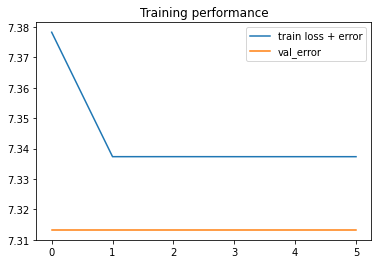

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

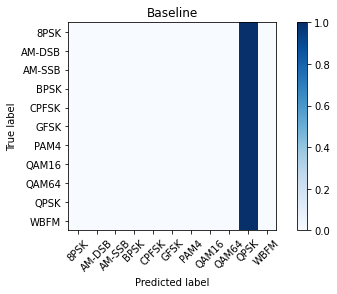

In [15]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.10104011887072809


Overall Accuracy:  0.08761552680221811


Overall Accuracy:  0.09508660303994344


Overall Accuracy:  0.09838369641602249


Overall Accuracy:  0.08020231213872832


Overall Accuracy:  0.09273182957393483


Overall Accuracy:  0.10462199928341097


Overall Accuracy:  0.09992732558139535


Overall Accuracy:  0.10081647142350018


Overall Accuracy:  0.0884255930984903


Overall Accuracy:  0.08533042846768336


Overall Accuracy:  0.09304002884962134


Overall Accuracy:  0.0872865275142315


Overall Accuracy:  0.09104477611940298


Overall Accuracy:  0.09654178674351585


Overall Accuracy:  0.0922347794385709


Overall Accuracy:  0.09329877823028508


Overall Accuracy:  0.09176382098533283


Overall Accuracy:  0.08069270449521002


Overall Accuracy:  0.08530465949820788


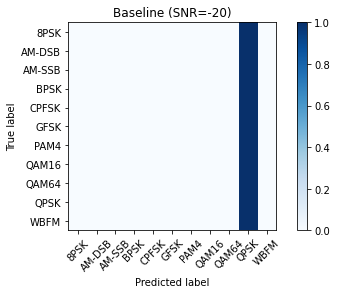

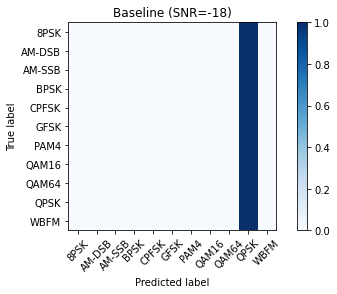

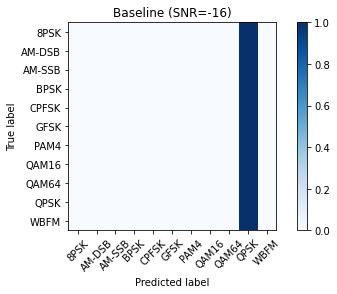

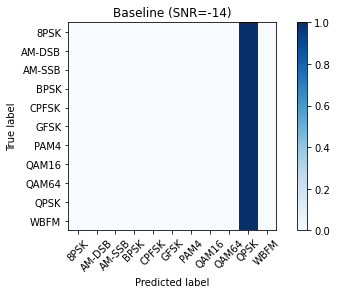

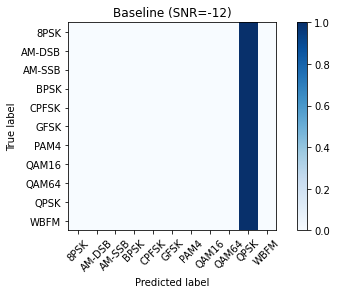

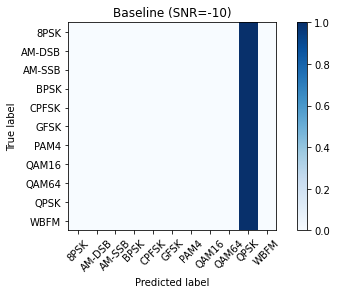

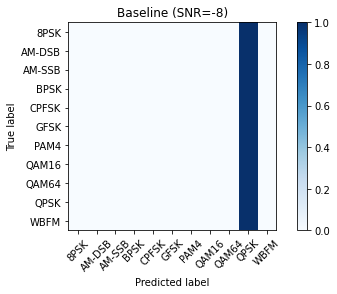

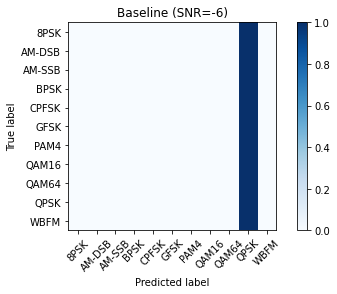

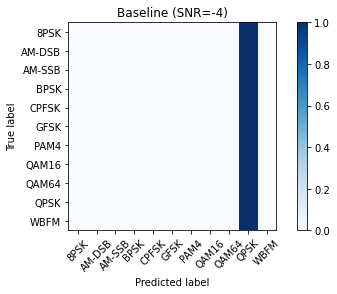

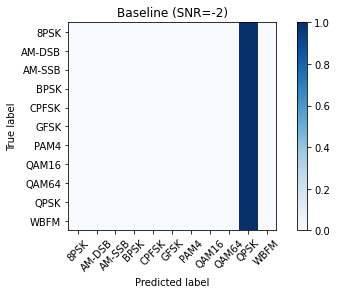

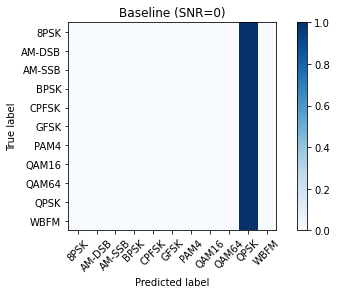

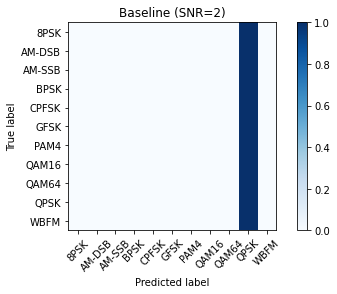

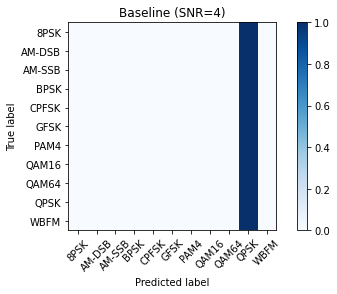

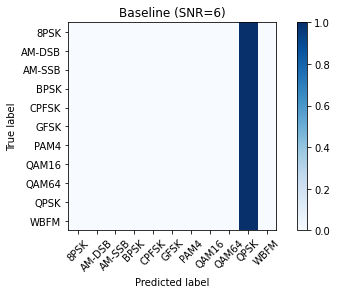

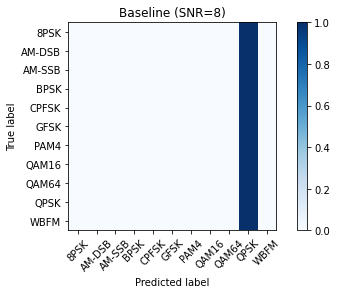

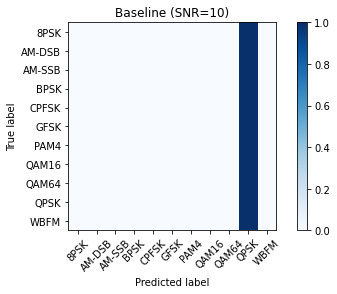

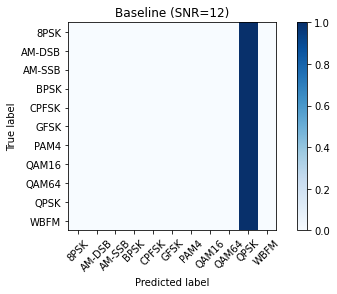

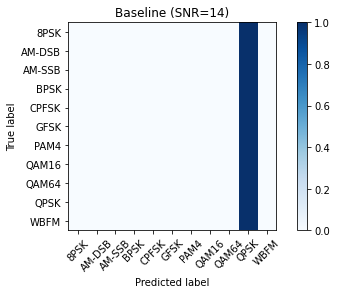

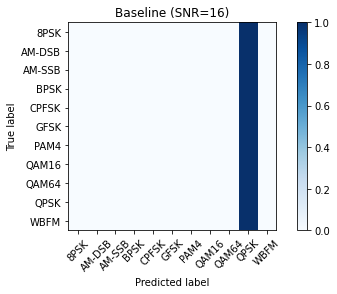

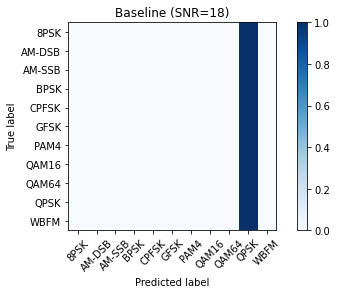

In [16]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [17]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,10,8,9,9,8,9,10,9,10,8,8,9,8,9,9,9,9,9,8,8


In [18]:
import statistics

statistics.mean(acc.values())

0.09226948832852169

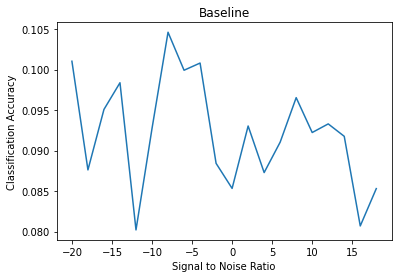

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)